In [1]:
import numpy as np
from matplotlib import pyplot as plt
# ----- Cord for importing .ipynb file as module -----
import sys  
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
# ----------------------------------------------------
from activations import *
from optimizer import *


class nn_module:
    def __init__(self, layers_dims, init_weight_range):
        self.params = {}
        self.grads = {}
        self.outputs = {}
        self.L = len(layers_dims)
        for l in range(1, self.L):
            W = np.random.uniform(
                low = - init_weight_range,
                high = init_weight_range,
                size = (layers_dims[l-1], layers_dims[l])
            )
            b = np.zeros((1, layers_dims[l]))
            self.params['W' + str(l)] = W
            self.params['b' + str(l)] = b
            
    def forward_propagate(self, X, activations):
        f = activations['hidden_activation']
        g = activations['output_activation']
        # Input Layer
        self.outputs['A0'] = X
        A = self.outputs['A0']
        # Hidden Layers
        for l in range(1, self.L - 1):
            W = self.params['W' + str(l)]
            b = self.params['b' + str(l)]
            Z = np.dot(A, W) + b
            A = f(Z)
            self.outputs['Z' + str(l)] = Z
            self.outputs['A' + str(l)] = A
        # Output Layer
        W = self.params['W' + str(self.L - 1)]
        b = self.params['b' + str(self.L - 1)]
        Z = np.dot(A, W) + b
        A = g(Z)
        self.outputs['Z' + str(self.L - 1)] = Z
        self.outputs['A' + str(self.L - 1)] = A
        
    def compute_cost(self, Y):
        N = Y.shape[0]
        AL = self.outputs['A' + str(self.L - 1)]
        # Cost function is cross entoropy loss
        cost = - np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)) / N
        cost = np.squeeze(cost)
        # --------------------------------------------------------------
        assert(cost.shape == ())
        # --------------------------------------------------------------
        return cost
    
    def back_propagate(self, Y, activations):
        N = Y.shape[0]
        df = activations['derivative_hidden_activation']
        dg = activations['derivative_output_activation']
        # Output Layer
        A = self.outputs['A' + str(self.L - 1)]
        A_prev = self.outputs['A' + str(self.L - 2)]
        Z = self.outputs['Z' + str(self.L - 1)]
        dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A)) / N
        dZ = dA * dg(Z)
        dW = np.dot(A_prev.T, dZ)
        db = np.sum(dZ, axis = 0, keepdims = True)
        # --------------------------------------------------------------
        assert(dA.shape == A.shape)
        assert(dW.shape == self.params['W' + str(self.L - 1)].shape)
        assert(db.shape == self.params['b' + str(self.L - 1)].shape)
        # --------------------------------------------------------------
        self.grads['W' + str(self.L - 1)] = dW
        self.grads['b' + str(self.L - 1)] = db
        # Hidden Layers
        for l in reversed(range(1, self.L - 1)):
            W = self.params['W' + str(l + 1)]
            A = self.outputs['A' + str(l)]
            A_prev = self.outputs['A' + str(l - 1)]
            Z = self.outputs['Z' + str(l)]
            dA = np.dot(dZ, W.T)
            dZ = dA * df(Z)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis = 0, keepdims = True)
            # ----------------------------------------------------------
            assert(dA.shape == A.shape)
            assert(dW.shape == self.params['W' + str(l)].shape)
            assert(db.shape == self.params['b' + str(l)].shape)
            # ----------------------------------------------------------
            self.grads['W' + str(l)] = dW
            self.grads['b' + str(l)] = db

    def SGD(self, lr):
        for key in self.params.keys():
            self.params[key] -= lr * self.grads[key]
    
            
    def test_nn(self, X, activations):
        f = activations['hidden_activation']
        g = activations['output_activation']
        # Input Layer
        A = X
        # Hidden Layers
        for l in range(1, self.L - 1):
            W = self.params['W' + str(l)]
            b = self.params['b' + str(l)]
            Z = np.dot(A, W) + b
            A = f(Z)
        # Output Layer
        W = self.params['W' + str(self.L - 1)]
        b = self.params['b' + str(self.L - 1)]
        Z = np.dot(A, W) + b
        A = g(Z)
        return A

1 0.6956744519387191
1000 0.32841697135847764
2000 0.13212920652982854
3000 0.06664669438668784
4000 0.037781834697779085
5000 0.02277470030844457
6000 0.014208751825932854
7000 0.009045203791374263
8000 0.005828993948573323
8354 0.004999304575023548
----- Learning End -----


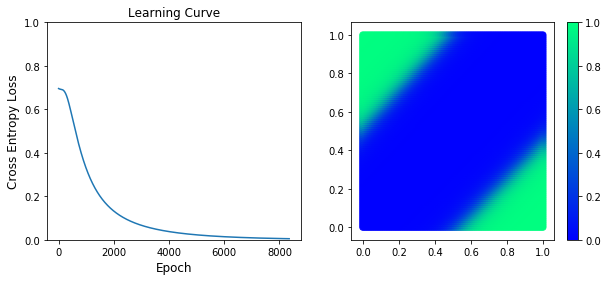

In [12]:
if __name__=='__main__':
    # ------< Hyperparameter >------
    epochs = 10000
    error_boundary = 5e-3
    structure = [2, 2, 1]
#     init_weight_range = (6 / (structure[0] + structure[-1])) ** 0.5
    init_weight_range = 1.0
    nn = nn_module(structure, init_weight_range)
    optimizer = Adam(nn)
#     lr = 1.0
#     optimizer = SGD(nn, lr)
    """
    Choose activate functions of hidden layers and output layer.
    Sigmoid, ReLU, tanh can be choosen for activate functions.
    name_haf: Name of Hidden-layers Activate Function
    name_oaf: Name of Output-layer Activate Function
    """
    activations = return_activations(
        name_haf = 'tanh',
        name_oaf = 'sigmoid'
    )
    
    # ------< Training and Teaching Data >------
    X = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])
    Y = np.array([[0.0], [1.0], [1.0], [0.0]])
    
    # ------< Learning Data >------
    cost = []
    training_data_indexes = np.arange(len(X))
    for epoch in range(1, epochs+1):
        nn.forward_propagate(X, activations)
        cost.append(nn.compute_cost(Y))
        nn.back_propagate(Y, activations)
        optimizer.update_params()
#         nn.Adam(epoch)
        if epoch % 1000 == 0 or epoch == 1:
            print(epoch, cost[-1])
#             print(nn.params['vW1'])
        if cost[-1] < error_boundary:
            print(epoch, cost[-1])
            print('----- Learning End -----')
            break

    # ------< Plot Learning Result >------
    x = np.arange(0.0, 1.01, 0.01)
    y = np.arange(0.0, 1.01, 0.01)
    z = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            inputs = np.array([[x[i], y[j]]])
            outputs = nn.test_nn(inputs, activations)
            z[i][j] = np.squeeze(outputs)
    x, y = np.meshgrid(x, y)

    plt.figure(figsize = (10, 4))
    plt.subplot(121)
    plt.plot(np.arange(len(cost)), cost)
    plt.title('Learning Curve')
    plt.xlabel('Epoch', fontsize = 12)
    plt.ylabel('Cross Entropy Loss', fontsize = 12)
    plt.ylim(0.0, 1.0)

    plt.subplot(122)
    plt.scatter(x, y, c = z, cmap = 'winter', vmin = 0, vmax = 1)
    plt.colorbar()